In [97]:
import random
import time
from uxsim import *
from IPython.display import display, Image

In [98]:
#Map
W = World(
    name="basic_demo",    # Scenario name. Can be blank. Used as the folder name for saving results.
    deltan=5,   # Simulation aggregation unit Δn. Defines how many vehicles are grouped together (i.e., platoon size) for computation. Computation cost is generally inversely proportional to deltan^2.
    tmax=1200,  # Total simulation time (s)
    print_mode=1, save_mode=1, show_mode=1,    # Various options. print_mode determines whether to print information. Usually set to 1, but recommended 0 when running multiple simulations automatically. save_mode determines if visualization results are saved. show_mode determines if visualization results are displayed. It's good to set show_mode=1 on Jupyter Notebook, otherwise recommended 0.
    random_seed=0    # Set the random seed. Specify if you want repeatable experiments. If not, set to None.
)

In [99]:
#Node and connection
W.addNode("orig1", 0, 0) #Create a node. Parameters: node name, visualization x-coordinate, visualization y-coordinate
W.addNode("orig2", 0, 2)
W.addNode("merge", 1, 1)
W.addNode("dest", 2, 1)

W.addLink("link1", "orig1", "merge", length=1000, free_flow_speed=20, number_of_lanes=1, merge_priority=0.5) # Create a link. Parameters: link name, start node, end node, length, free_flow_speed, number of lanes, merge_priority during merging
W.addLink("link2", "orig2", "merge", length=1000, free_flow_speed=20, number_of_lanes=1, merge_priority=2)
W.addLink("link3", "merge", "dest", length=1000, free_flow_speed=20, number_of_lanes=1)

#Traffic demand
W.adddemand("orig1", "dest", 0, 1000, 0.4) # Create OD traffic demand. Parameters: origin node, destination node, start time, end time, demand flow rate
W.adddemand("orig2", "dest", 500, 1000, 0.6)


W_withddos = W.copy() # Create a copy of the original map for DDoS simulation
W_withddos.adddemand("orig1", "dest", 0, 1000, 0.4) # Create OD traffic demand. Parameters: origin node, destination node, start time, end time, demand flow rate   
W_withddos.adddemand("orig2", "dest", 500, 1000, 0.6)

In [100]:
def red_agent(world, source_node, target_nodes, intensity=100, interval=1, start_time=0, duration=10, packet_size=64):
    
    # Check if the source node exists in the world
    all_nodes = world.getNodes() if hasattr(world, 'getNodes') else []
    if source_node not in all_nodes and len(all_nodes) > 0:
        raise ValueError(f"The source node '{source_node}' does not exist in the world")
    
    # Check if the target nodes exist
    for target in target_nodes:
        if target not in all_nodes and len(all_nodes) > 0:
            raise ValueError(f"The target node '{target}' does not exist in the world")
    
    # List to store packet IDs
    packet_ids = []
    
    # Schedule packet sending
    current_time = start_time
    end_time = start_time + duration
    packet_count = 0
    
    while current_time < end_time:
        for target in target_nodes:
            for i in range(intensity):
                packet_id = f"red_packet_{packet_count}"
                
                try:
                    # Try to use addPacket if available
                    if hasattr(world, 'addPacket'):
                        world.addPacket(
                            source_node,    # source
                            target,         # destination
                            current_time,   # send time
                            packet_size,    # packet size/attribute
                            packet_id       # unique packet ID
                        )
                    # Otherwise, use addVehicle (since packets can be modeled as vehicles)
                    else:
                        world.addVehicle(
                            source_node,    # source
                            target,         # destination 
                            current_time,   # departure time
                            packet_id,      # vehicle/packet ID
                            size=packet_size # size as attribute
                        )
                    
                    packet_ids.append(packet_id)
                    packet_count += 1
                    
                except Exception as e:
                    print(f"Error adding packet {packet_id}: {str(e)}")
        
        current_time += interval
    
    print(f"Malicious agent created!")
    print(f"A total of {packet_count} packets scheduled for sending between t={start_time} and t={end_time}")
    
    return packet_ids


In [101]:
# Correction of signal_group
for link in W.LINKS:
    if hasattr(link, 'signal_group') and isinstance(link.signal_group, int):
        link.signal_group = [link.signal_group]


simulation setting:
 scenario name: basic_demo
 simulation duration:	 1200 s
 number of vehicles:	 700 veh
 total road length:	 3000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 240
 number of platoons:	 140
 number of links:	 3
 number of nodes:	 4
 setup time:		 0.78 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      100 vehs|  17.5 m/s|     0.09 s
    1200 s|       25 vehs|  20.0 m/s|     0.20 s
 simulation finished
 generating animation...


100%|██████████| 120/120 [00:21<00:00,  5.64it/s]


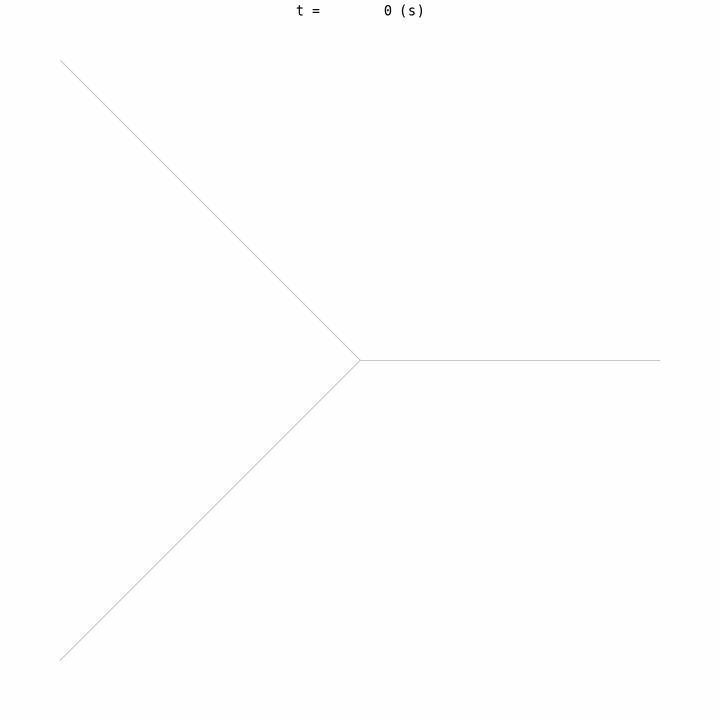

In [102]:
#World without DDoS

W.exec_simulation()

#Plot
W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3, interval=3, trace_length=3, network_font_size=0)

with open("outbasic_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__() got an unexpected keyword argument 'size'
Error adding packet red_packet_0: Vehicle.__init__

100%|██████████| 120/120 [00:21<00:00,  5.56it/s]


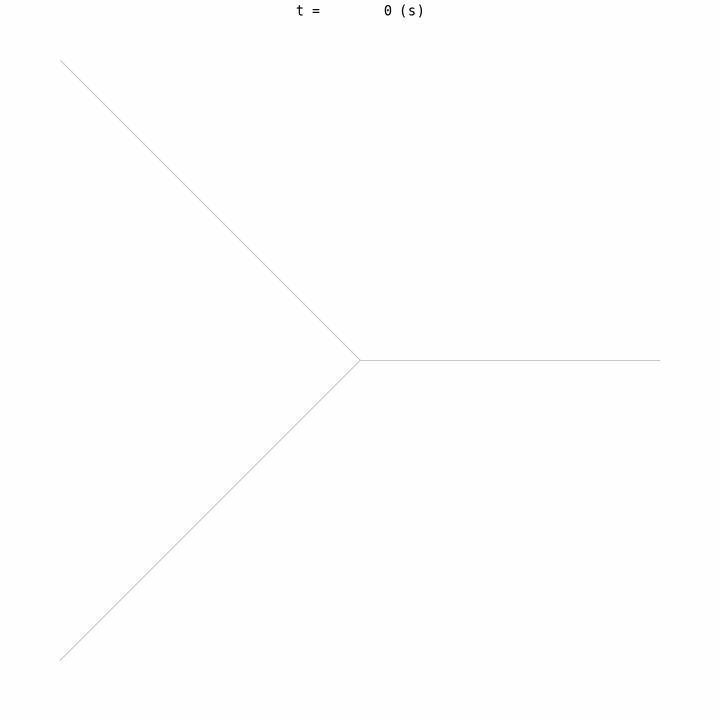

In [103]:
#World with DDoS

red_agent(
    world=W_withddos, 
    source_node="attacker", 
    target_nodes=["orig1", "orig2", "dest"], # List of target nodes
    intensity=20,        # 20 packets per interval to each target
    interval=5,          # every 5 seconds of simulation
    start_time=10.0,     # starts at t=10s
    duration=60.0,       # attack lasts for 60 seconds
    packet_size=64       # size of 64 (unit depends on the implementation)
)

W_withddos.exec_simulation()

# Plot
W_withddos.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3, interval=3, trace_length=3, network_font_size=0)

with open("outbasic_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))


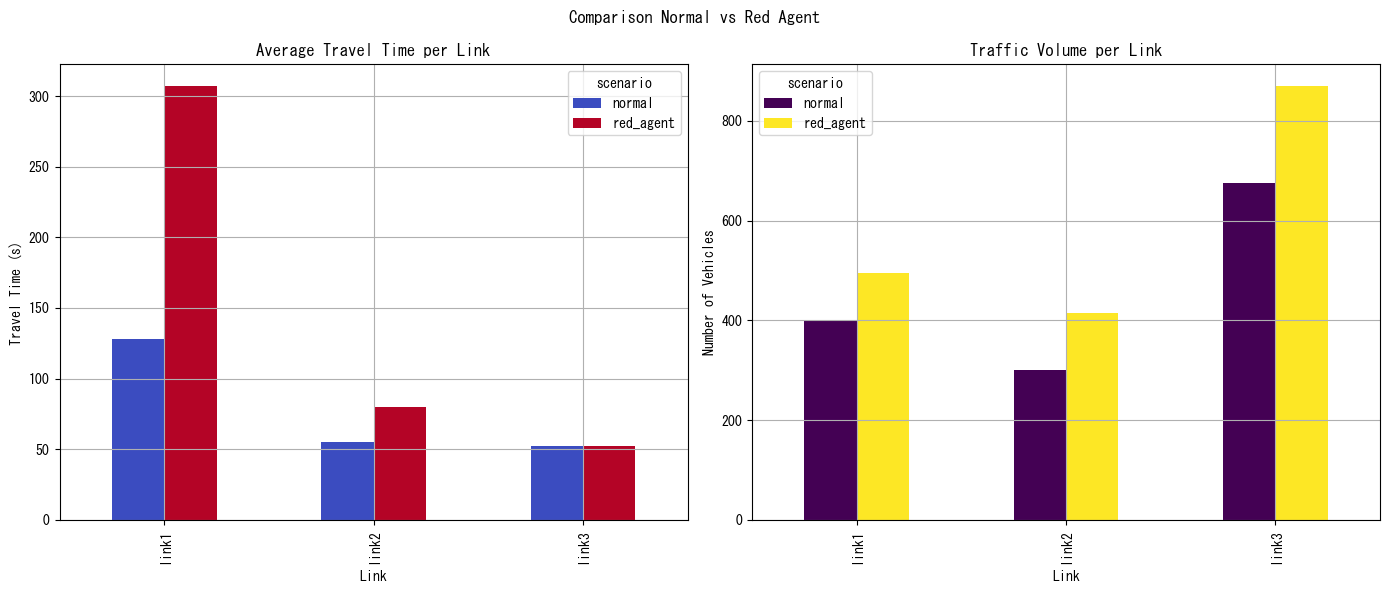

In [104]:
# Get link-level data for both worlds
df_normal = W.analyzer.link_to_pandas()
df_ddos = W_withddos.analyzer.link_to_pandas()
# Add a new column to distinguish the scenarios
df_normal["scenario"] = "normal"
df_ddos["scenario"] = "red_agent"
# Combine both DataFrames
df_combined = pd.concat([df_normal, df_ddos], ignore_index=True)
# Save both full and filtered versions
df_combined.to_csv("combined_link_data.csv", index=False)

# Load the CSV file
df = pd.read_csv("combined_link_data.csv")

# Keep only the useful columns
df_plot = df[["link", "average_travel_time", "traffic_volume", "scenario"]]

# Pivot for easy comparison
df_time = df_plot.pivot(index="link", columns="scenario", values="average_travel_time")
df_traffic = df_plot.pivot(index="link", columns="scenario", values="traffic_volume")

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Average travel time
df_time.plot(kind='bar', ax=axes[0], colormap="coolwarm")
axes[0].set_title("Average Travel Time per Link")
axes[0].set_ylabel("Travel Time (s)")
axes[0].set_xlabel("Link")
axes[0].grid(True)

# 2. Traffic volume
df_traffic.plot(kind='bar', ax=axes[1], colormap="viridis")
axes[1].set_title("Traffic Volume per Link")
axes[1].set_ylabel("Number of Vehicles")
axes[1].set_xlabel("Link")
axes[1].grid(True)

plt.suptitle("Comparison Normal vs Red Agent")
plt.tight_layout()
plt.show()
